In [150]:
# Import Library
#%reset
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import keras
from glob import glob
from keras.preprocessing.image import ImageDataGenerator #, img_to_array, 
from tensorflow.keras.utils import img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dense,Flatten
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.mobilenet_v2 import MobileNetV2
import os
import pickle
import warnings
warnings.filterwarnings("ignore")
from PIL import Image
import tensorflow as tf

#Usare scaler

# Prepare and Review Dataset

In [151]:
# Test and Train path
with open('./pickles/newResa3.pickle', 'rb') as handle:
    newResa3 = pickle.load(handle)

with open('./pickles/AllPixelBand3.pickle', 'rb') as handle:
    allPixel3 = pickle.load(handle)

# Identificare qualita' e suddivisione del dataset in maniera corretta tra train e test

Low yield: 58 Medium yield [4500,10000]: 1472 High yield(>10000): 31


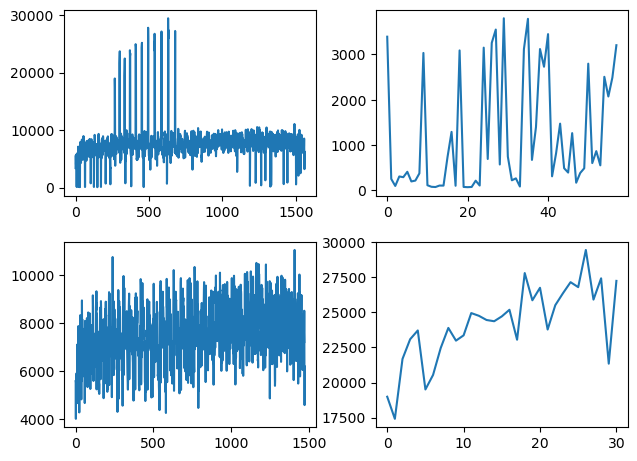

In [152]:
#Cut outlier
FilterResa3gtZero = newResa3!=0
newResa3 = newResa3[FilterResa3gtZero]
allPixel3 = allPixel3[FilterResa3gtZero,:,:]

LowValue = 1
Medium = 4000
HighValue = 12000
Resa3LowFilter = (newResa3<Medium) & (newResa3>LowValue)
Resa3MediumFilter = (newResa3>=Medium) & (newResa3<=HighValue)
Resa3HighFilter = (newResa3>HighValue)

Resa3Low = newResa3[Resa3LowFilter]
Resa3Medium = newResa3[Resa3MediumFilter]
Resa3High = newResa3[Resa3HighFilter]

Pixel3Low = allPixel3[Resa3LowFilter,:,:]
Pixel3Medium = allPixel3[Resa3MediumFilter,:,:]
Pixel3High = allPixel3[Resa3HighFilter,:,:]


print("Low yield: "+str(len(Resa3Low))+ " Medium yield [4500,10000]: "+ str(len(Resa3Medium))+ " High yield(>10000): "+ str(len(Resa3High)))

padding = 1.2
f, axarr = plt.subplots(2,2)
f.tight_layout(pad=padding)
axarr[0][0].plot(newResa3)
axarr[0][1].plot(Resa3Low)
axarr[1][0].plot(Resa3Medium)
axarr[1][1].plot(Resa3High)
plt.show()

In [153]:
Resa3Medium = Resa3Medium/Resa3Medium.max()
Pixel3Medium = Pixel3Medium/Pixel3Medium.max()

1185


(array([ 1.,  4.,  3.,  4., 10., 14., 18., 23., 26., 28., 26., 15., 13.,
        19., 25., 23., 22., 23., 26., 28., 32., 30., 25., 23., 16., 20.,
        35., 44., 26., 19., 10.,  5.,  3.,  1.,  1.,  1.]),
 array([0.36391   , 0.38157916, 0.39924833, 0.4169175 , 0.43458664,
        0.45225582, 0.469925  , 0.48759416, 0.5052633 , 0.52293247,
        0.5406017 , 0.5582708 , 0.57594   , 0.59360915, 0.61127836,
        0.6289475 , 0.64661664, 0.66428584, 0.681955  , 0.6996242 ,
        0.7172933 , 0.7349625 , 0.75263166, 0.7703008 , 0.78797   ,
        0.80563915, 0.82330835, 0.8409775 , 0.8586467 , 0.87631583,
        0.893985  , 0.9116542 , 0.9293233 , 0.9469925 , 0.96466166,
        0.98233086, 1.        ], dtype=float32),
 <a list of 36 Patch objects>)

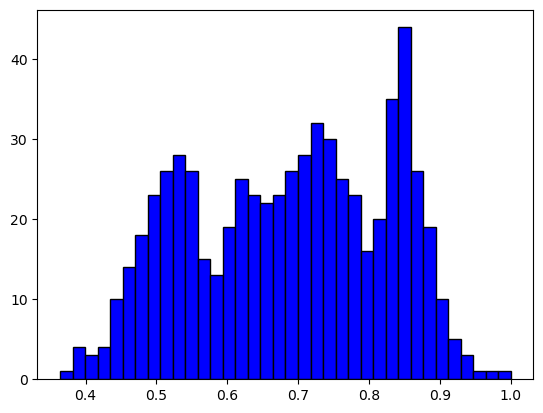

In [154]:

Resa3Undesampling = (Resa3Medium>=0.55) & (Resa3Medium<=0.83)

trueList = np.argwhere(Resa3Undesampling == True).flatten()
print(trueList.shape[0])
falseList = np.argwhere(Resa3Undesampling == False).flatten()
flipToFalse = np.random.choice(range(trueList.shape[0]), size=(int(trueList.shape[0]*0.3),), replace=False)

SampleList = np.concatenate((falseList,trueList[flipToFalse]))

Resa3Sampled = Resa3Medium[SampleList]
Pixel3Sampled = Pixel3Medium[SampleList,:,:]
import seaborn as sns
plt.hist(Resa3Sampled, color = 'blue', edgecolor = 'black',
         bins = int(180/5))

In [155]:
def splitSet(X,Y):
    if X.shape[0] != Y.shape[0]:
        raise Exception("X and Y have different sizes")
    choice = np.random.choice(range(X.shape[0]), size=(int(X.shape[0]*0.8),), replace=False)
    ind = np.zeros(X.shape[0], dtype=bool)
    ind[choice] = True
    rest = ~ind
    return np.array(X[ind,:,:]),np.array(Y[ind]),np.array(X[rest,:,:]),np.array(Y[rest])

# Costruisco le immagini

[0.54760486 0.4231381  0.4974422  0.5210141  0.6320499  0.71325016
 0.4654555  0.6128344  0.5161786  0.38800615]


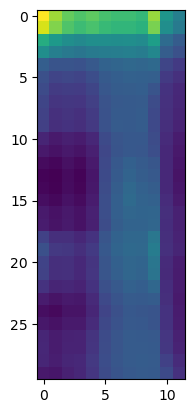

In [156]:

training_setMediumX,training_setMediumY, test_setMediumX, test_setMediumY = splitSet(Pixel3Medium,Resa3Medium)

training_setX = training_setMediumX
training_setY = training_setMediumY

test_setX = test_setMediumX
test_setY = test_setMediumY

print(training_setY[10:20])
plt.imshow(np.transpose(training_setX[0,:,:]))


# Image augmentation

In [157]:
def multiplyImg(img):
    newImg = np.concatenate((img,img,img),axis = 1)
    newImg = np.concatenate((newImg,newImg),axis = 2)
    newImg = np.stack([newImg,newImg,newImg], axis=3)
    return newImg

(1177, 36, 60, 3)


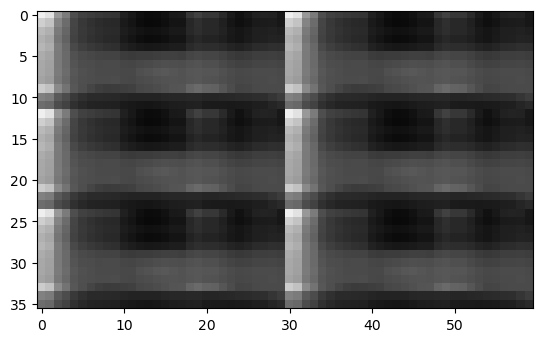

In [158]:
inputSize = (36,60)
training_setX = multiplyImg(training_setX)
test_setX = multiplyImg(test_setX)
print(training_setX.shape)
plt.imshow(training_setX[0])

# Creazione del modello di MobileNetV2

In [159]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=inputSize+(3,),
                                               include_top=False,
                                               weights='imagenet')

In [160]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 36, 60, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 18, 30, 32)   864         ['input_5[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 18, 30, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 18, 30, 32)   0           ['bn_Conv1[0][0]']               
                                                                               

In [161]:
base_model.trainable = False

#base_model.trainable = True
# Fine-tune from this layer onwards
fine_tune_at = 0
#
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:-fine_tune_at]:
  layer.trainable =  True

In [162]:
model = Sequential()

In [163]:
model.add(base_model)
model.add(Flatten())
model.add(Dense(2048,activation='relu'))
model.add(Dense(1,activation='linear'))


In [164]:
# After I added last layer in created model.
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 2, 2, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_4 (Flatten)         (None, 5120)              0         
                                                                 
 dense_8 (Dense)             (None, 2048)              10487808  
                                                                 
 dense_9 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 12,747,841
Trainable params: 10,489,857
Non-trainable params: 2,257,984
_________________________________________________________________


In [165]:
# I create compile part.
model.compile(loss = "mean_squared_error",
             optimizer = "adam",
             metrics = ["mse","mae"])

# Training Model 

In [166]:
# Traning with model
batch_size = 32

hist_model = model.fit(training_setX, training_setY,
                                epochs = 30,
                                validation_data=(test_setX,test_setY)
                                )

Epoch 1/30
37/37 [==============================] - 8s 135ms/step - loss: 37.5389 - mse: 37.5389 - mae: 3.5377 - val_loss: 0.4637 - val_mse: 0.4637 - val_mae: 0.6462
Epoch 2/30
37/37 [==============================] - 4s 109ms/step - loss: 0.0974 - mse: 0.0974 - mae: 0.2369 - val_loss: 0.0201 - val_mse: 0.0201 - val_mae: 0.1165
Epoch 3/30
37/37 [==============================] - 4s 109ms/step - loss: 0.0121 - mse: 0.0121 - mae: 0.0868 - val_loss: 0.0100 - val_mse: 0.0100 - val_mae: 0.0774
Epoch 4/30
37/37 [==============================] - 4s 109ms/step - loss: 0.0090 - mse: 0.0090 - mae: 0.0733 - val_loss: 0.0084 - val_mse: 0.0084 - val_mae: 0.0712
Epoch 5/30
37/37 [==============================] - 4s 109ms/step - loss: 0.0081 - mse: 0.0081 - mae: 0.0698 - val_loss: 0.0086 - val_mse: 0.0086 - val_mae: 0.0729
Epoch 6/30
37/37 [==============================] - 4s 110ms/step - loss: 0.0082 - mse: 0.0082 - mae: 0.0702 - val_loss: 0.0088 - val_mse: 0.0088 - val_mae: 0.0750
Epoch 7/30
37/

In [ ]:
# Save the weights of model
#vgg16Model.save_weights("previsioneResa.h5")

# Andiamo a visualizzare i risultati della rete

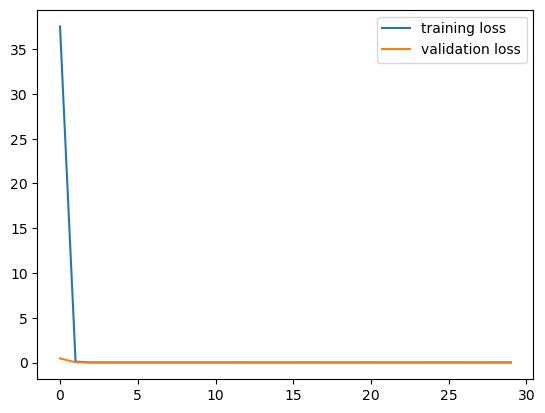

In [167]:

# Loss and Validation Loss

plt.plot(hist_model.history["loss"], label = "training loss")
plt.plot(hist_model.history["val_loss"], label = "validation loss")
plt.legend()
plt.show()

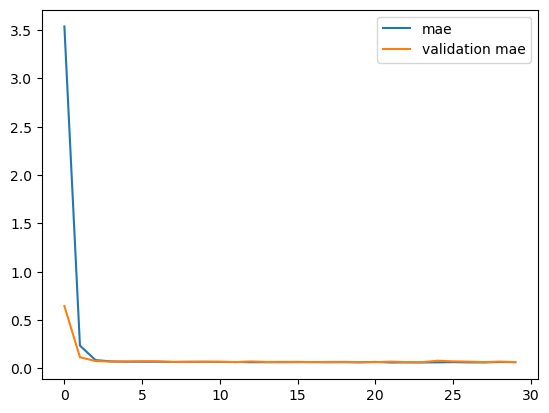

In [168]:
# Accuracy and Validation Accuracy
plt.plot(hist_model.history["mae"], label = "mae")
plt.plot(hist_model.history["val_mae"], label = "validation mae")
plt.legend()
plt.show()

In [169]:
true_y = test_setY
print(len(true_y))
pred_y = model.predict(test_setX)

295
10/10 [==============================] - 1s 36ms/step


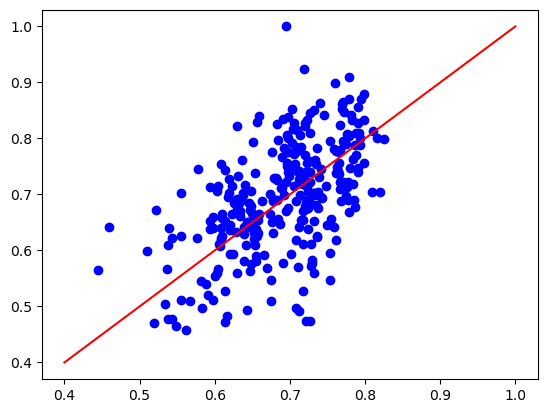

In [170]:

import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms


#lineStart = data_calc_hourly.temp.min() 
#lineEnd = data_calc_hourly.temp.max()  
fig, ax = plt.subplots()
ax.scatter(pred_y, true_y, c='blue')
line = mlines.Line2D([0.4, 1], [0.4, 1], color='red')
transform = ax.transAxes
#line.set_transform(transform)
ax.add_line(line)
plt.show()

# calculate the metrics

In [171]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

predizione = pred_y
present = true_y


# calculate MAE
error1 = np.round(mae(true_y, pred_y),6)
print("Mean absolute error : " + str(error1))

# calculate MSE
error2 = round(mse(present, predizione),6)
print("Mean Square error : " + str(error2))
# calculate RMSE
print("R - Mean Square error : " + str(np.round(np.sqrt(error2),6)))

Mean absolute error : 0.065692
Mean Square error : 0.007001
R - Mean Square error : 0.083672


# Salviamo e carichiamo i risultati

In [161]:
'''import json, codecs
with open("previsioneResa.json","w") as f:
    json.dump(hist_vgg16.history, f)'''

'import json, codecs\nwith open("previsioneResa.json","w") as f:\n    json.dump(hist_vgg16.history, f)'

In [162]:
'''with codecs.open("./previsioneResa.json","r", encoding = "utf-8") as f:
    load_result = json.loads(f.read())'''

'with codecs.open("./previsioneResa.json","r", encoding = "utf-8") as f:\n    load_result = json.loads(f.read())'